# Variational classifier
Use PennyLane to implement variational quantum classifiers - quantum circuits that can be trained from labelled data to classify new data samples


## Fitting the parity function

In [2]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer

In [3]:
dev = qml.device("default.qubit")

### layer function 
1. The function `layer` takes a single argument, `layer_weights`, which is expected to be a list of weights for each wire in the circuit.
2. Inside the function:
    - It iterates over the range of 4 wires (0 to 3).
    - For each wire, it applies a single-qubit rotation gate (`qml.Rot`) with the corresponding weights from `layer_weights`.
    - Next, it applies controlled-NOT (CNOT) gates between adjacent wires: [0, 1], [1, 2], [2, 3], and [3, 0].



In [4]:
def layer(layer_weights):
    for wire in range(4):
        qml.Rot(*layer_weights[wire], wires=wire)

    for wires in ([0, 1], [1, 2], [2, 3], [3, 0]):
        qml.CNOT(wires)

### State Preparation
  - **`qml.BasisState`**: This operation prepares a computational basis state. The argument `x` is an array of integers (0 or 1) that specifies the desired basis state.
  - **`wires=[0, 1, 2, 3]`**: This specifies the qubits (wires) on which the basis state is prepared. In this case, it acts on four qubits (wires 0, 1, 2, and 3).

For example, if `x = [1, 0, 1, 0]`, the function prepares the state $(|1010\rangle)$ on the specified wires.


In [5]:
def state_preparation(x):
    qml.BasisState(x, wires=[0, 1, 2, 3])

### Circuit

First it prepare the state then the loop iterates over the `weights` list, applying the `layer` function to each set of `layer_weights`. The `layer` function.

Finally, the circuit measures the expectation value of the Pauli-Z operator on the first qubit (wire 0).


In [6]:
@qml.qnode(dev)
def circuit(weights, x):
    state_preparation(x)

    for layer_weights in weights:
        layer(layer_weights)

    return qml.expval(qml.PauliZ(0))

### Classical Bias
This function combines quantum circuit computations with a "classical" bias (trainable) term to create a variational classifier.


In [7]:
def variational_classifier(weights, bias, x):
    return circuit(weights, x) + bias

### Square_loss

This function quantifies how well the model's predictions match the actual labels using the mean squared error. Lower values indicate better agreement between predictions and ground truth. 


In [8]:
def square_loss(labels, predictions):
    # We use a call to qml.math.stack to allow subtracting the arrays directly
    return np.mean((labels - qml.math.stack(predictions)) ** 2)

### Accuracy 
   - The purpose of this function is to compute the accuracy between the target labels and the model's predictions.
   - It iterates through corresponding pairs of `labels` and `predictions`.
   - For each pair, it checks if the absolute difference (`abs(l - p)`) is less than a small threshold (here, $10^{-5}$ ).
   - If the condition is met (i.e., the prediction is close enough to the true label), it increments the accuracy count.
   - Finally, it computes the accuracy as the ratio of the accurate predictions to the total number of data points.



In [9]:
def accuracy(labels, predictions):
    acc = sum(abs(l - p) < 1e-5 for l, p in zip(labels, predictions))
    acc = acc / len(labels)
    return acc

### Cost
   - The purpose of this function is to compute the cost (loss) associated with the predictions made by a variational quantum classifier.
   - It first computes the predictions for each input data point by evaluating the `variational_classifier(weights, bias, x)` for each `x` in `X`.
   - Next, it calculates the square loss (mean squared error) between the predicted values and the labels using the `square_loss` function.
   - The function returns the computed cost based on the squared differences between predictions and actual labels.




In [10]:
def cost(weights, bias, X, Y):
    predictions = [variational_classifier(weights, bias, x) for x in X]
    return square_loss(Y, predictions)

### Optimization

 **Data Processing**:
   - `X = np.array(data[:, :-1])`: Extracts all columns except the last one (features) and stores them in `X`.
   - `Y = np.array(data[:, -1])`: Extracts the last column (labels) and stores it in `Y`.
   - `Y = Y * 2 - 1`: Shifts the labels from {0, 1} to {-1, 1} (useful for binary classification).


For example, if the data file contains rows like `[1, 0, 1, 0, 1]`, the output will be:
```
x = [1 0 1 0], y = 1
```



In [11]:
data = np.loadtxt("variational_classifier/data/parity_train.txt", dtype=int)
X = np.array(data[:, :-1])
Y = np.array(data[:, -1])
Y = Y * 2 - 1  # shift label from {0, 1} to {-1, 1}

for x,y in zip(X, Y):
    print(f"x = {x}, y = {y}")

x = [0 0 0 1], y = 1
x = [0 0 1 0], y = 1
x = [0 1 0 0], y = 1
x = [0 1 0 1], y = -1
x = [0 1 1 0], y = -1
x = [0 1 1 1], y = 1
x = [1 0 0 0], y = 1
x = [1 0 0 1], y = -1
x = [1 0 1 1], y = 1
x = [1 1 1 1], y = -1


###  Random initialization of wieght and bias
1. Setting the Random Seed:
   - `np.random.seed(0)`: This sets the random seed for NumPy's random number generator. It ensures reproducibility by generating the same random numbers each time the code runs.

2. Variables:
   - `num_qubits`: The number of qubits (quantum bits) in the system (here, 4).
   - `num_layers`: The number of layers in the quantum circuit (here, 2).
   - `weights_init`: A 4D array (tensor) representing the initial weights for the quantum circuit. It has dimensions `(num_layers, num_qubits, 3)`.
   - `bias_init`: A scalar representing the initial bias term.

3. Weight Initialization:
   - `0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)`: This initializes the weights randomly using a normal distribution with mean 0 and standard deviation 1. The `requires_grad=True` indicates that these weights will be optimized during training.




In [12]:
np.random.seed(0)
num_qubits = 4
num_layers = 2
weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

print("Weights:", weights_init)
print("Bias: ", bias_init)

Weights: [[[ 0.01764052  0.00400157  0.00978738]
  [ 0.02240893  0.01867558 -0.00977278]
  [ 0.00950088 -0.00151357 -0.00103219]
  [ 0.00410599  0.00144044  0.01454274]]

 [[ 0.00761038  0.00121675  0.00443863]
  [ 0.00333674  0.01494079 -0.00205158]
  [ 0.00313068 -0.00854096 -0.0255299 ]
  [ 0.00653619  0.00864436 -0.00742165]]]
Bias:  0.0


### optimizer instance

1. Nesterov Momentum Optimizer (`opt`):
   - The line `opt = NesterovMomentumOptimizer(0.5)` initializes an optimizer using Nesterov accelerated gradient (NAG) with a learning rate of 0.5.
   - Nesterov momentum is a variant of stochastic gradient descent (SGD) that helps accelerate convergence by considering the future gradient estimate during updates.

2. Batch Size (`batch_size`):
   - The line `batch_size = 5` sets the batch size for mini-batch optimization.
   - In machine learning, mini-batch gradient descent processes a subset (batch) of the training data at each iteration, which can improve efficiency and generalization.



In [13]:
opt = NesterovMomentumOptimizer(0.5)
batch_size = 5

### Training


1. Initialization:
   - Initializes the weights and bias with the previously generated random values.
2. Training Loop:
   - The loop runs for 100 iterations (`for it in range(100)`).
   - In each iteration:
     - A random batch of data points is selected (mini-batch training).
     - The weights and bias are updated using the optimizer (`opt.step`).
     - The cost and accuracy are computed based on the updated weights and bias.




In [14]:
weights = weights_init
bias = bias_init
for it in range(100):

    # Update the weights by one optimizer step, using only a limited batch of data
    batch_index = np.random.randint(0, len(X), (batch_size,))
    X_batch = X[batch_index]
    Y_batch = Y[batch_index]
    weights, bias = opt.step(cost, weights, bias, X=X_batch, Y=Y_batch)

    # Compute accuracy
    predictions = [np.sign(variational_classifier(weights, bias, x)) for x in X]

    current_cost = cost(weights, bias, X, Y)
    acc = accuracy(Y, predictions)

    print(f"Iter: {it+1:4d} | Cost: {current_cost:0.7f} | Accuracy: {acc:0.7f}")

Iter:    1 | Cost: 2.3147651 | Accuracy: 0.5000000
Iter:    2 | Cost: 1.9664866 | Accuracy: 0.5000000
Iter:    3 | Cost: 1.9208589 | Accuracy: 0.5000000
Iter:    4 | Cost: 2.6276126 | Accuracy: 0.5000000
Iter:    5 | Cost: 0.9323119 | Accuracy: 0.6000000
Iter:    6 | Cost: 1.1903549 | Accuracy: 0.5000000
Iter:    7 | Cost: 2.0508989 | Accuracy: 0.4000000
Iter:    8 | Cost: 1.1275531 | Accuracy: 0.6000000
Iter:    9 | Cost: 1.1659803 | Accuracy: 0.6000000
Iter:   10 | Cost: 1.1349618 | Accuracy: 0.6000000
Iter:   11 | Cost: 0.9994063 | Accuracy: 0.6000000
Iter:   12 | Cost: 1.0812559 | Accuracy: 0.6000000
Iter:   13 | Cost: 1.2863155 | Accuracy: 0.6000000
Iter:   14 | Cost: 2.2658259 | Accuracy: 0.4000000
Iter:   15 | Cost: 1.1323724 | Accuracy: 0.6000000
Iter:   16 | Cost: 1.3439737 | Accuracy: 0.8000000
Iter:   17 | Cost: 2.0076168 | Accuracy: 0.6000000
Iter:   18 | Cost: 1.2685760 | Accuracy: 0.5000000
Iter:   19 | Cost: 1.6762475 | Accuracy: 0.5000000
Iter:   20 | Cost: 1.1868237 | 

### Test


Predictions:
   -  Computes predictions for each test data point using the trained weight, bias.



In [15]:
data = np.loadtxt("variational_classifier/data/parity_test.txt", dtype=int)
X_test = np.array(data[:, :-1])
Y_test = np.array(data[:, -1])
Y_test = Y_test * 2 - 1  # shift label from {0, 1} to {-1, 1}

predictions_test = [np.sign(variational_classifier(weights, bias, x)) for x in X_test]

for x,y,p in zip(X_test, Y_test, predictions_test):
    print(f"x = {x}, y = {y}, pred={p}")

acc_test = accuracy(Y_test, predictions_test)
print("Accuracy on unseen data:", acc_test)

x = [0 0 0 0], y = -1, pred=-1.0
x = [0 0 1 1], y = -1, pred=-1.0
x = [1 0 1 0], y = -1, pred=-1.0
x = [1 1 1 0], y = 1, pred=1.0
x = [1 1 0 0], y = -1, pred=-1.0
x = [1 1 0 1], y = 1, pred=1.0
Accuracy on unseen data: 1.0


## Iris classification

### Quantum state preparation

1. `get_angles(x)` Function:
   - This function computes a set of angles based on an input vector `x`.
   - The computed angles are used to prepare a quantum state.
   - Specifically, it calculates angles (`beta0`, `beta1`, and `beta2`) based on ratios and norms of components in `x`.

2. `state_preparation(a)` Function:
   - This function constructs a quantum circuit that prepares a quantum state using the angles `a`.
   - The circuit includes single-qubit rotations (`RY` gates), controlled-NOT (`CNOT`) gates, and Pauli-X (`PauliX`) gates.
   - The resulting state is used as an initial state for further quantum computations.


In [16]:
def get_angles(x):
    beta0 = 2 * np.arcsin(np.sqrt(x[1] ** 2) / np.sqrt(x[0] ** 2 + x[1] ** 2 + 1e-12))
    beta1 = 2 * np.arcsin(np.sqrt(x[3] ** 2) / np.sqrt(x[2] ** 2 + x[3] ** 2 + 1e-12))
    beta2 = 2 * np.arcsin(np.linalg.norm(x[2:]) / np.linalg.norm(x))

    return np.array([beta2, -beta1 / 2, beta1 / 2, -beta0 / 2, beta0 / 2])


def state_preparation(a):
    qml.RY(a[0], wires=0)

    qml.CNOT(wires=[0, 1])
    qml.RY(a[1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[2], wires=1)

    qml.PauliX(wires=0)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[3], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[4], wires=1)
    qml.PauliX(wires=0)

### Test function 

In [17]:
x = np.array([0.53896774, 0.79503606, 0.27826503, 0.0], requires_grad=False)
ang = get_angles(x)


@qml.qnode(dev)
def test(angles):
    state_preparation(angles)

    return qml.state()


state = test(ang)

print("x               : ", np.round(x, 6))
print("angles          : ", np.round(ang, 6))
print("amplitude vector: ", np.round(np.real(state), 6))

x               :  [0.538968 0.795036 0.278265 0.      ]
angles          :  [ 0.563975 -0.        0.       -0.975046  0.975046]
amplitude vector:  [ 0.538968  0.795036  0.278265 -0.      ]


### Layer function for 2 qubits

In [18]:
def layer(layer_weights):
    for wire in range(2):
        qml.Rot(*layer_weights[wire], wires=wire)
    qml.CNOT(wires=[0, 1])


def cost(weights, bias, X, Y):
    # Transpose the batch of input data in order to make the indexing
    # in state_preparation work
    predictions = variational_classifier(weights, bias, X.T)
    return square_loss(Y, predictions)

### Preprocess the dataset 

- Loading and extracting features and labels.
- Padding and normalizing the feature vectors.
- Computing angles for quantum state preparation.
- Preparing the data for use in a variational quantum classifier.


In [19]:
data = np.loadtxt("variational_classifier/data/iris_classes1and2_scaled.txt")
X = data[:, 0:2]
print(f"First X sample (original)  : {X[0]}")

# pad the vectors to size 2^2=4 with constant values
padding = np.ones((len(X), 2)) * 0.1
X_pad = np.c_[X, padding]
print(f"First X sample (padded)    : {X_pad[0]}")

# normalize each input
normalization = np.sqrt(np.sum(X_pad**2, -1))
X_norm = (X_pad.T / normalization).T
print(f"First X sample (normalized): {X_norm[0]}")

# the angles for state preparation are the features
features = np.array([get_angles(x) for x in X_norm], requires_grad=False)
print(f"First features sample      : {features[0]}")

Y = data[:, -1]

First X sample (original)  : [0.4  0.75]
First X sample (padded)    : [0.4  0.75 0.1  0.1 ]
First X sample (normalized): [0.46420708 0.87038828 0.11605177 0.11605177]
First features sample      : [ 0.32973573 -0.78539816  0.78539816 -1.080839    1.080839  ]


### Visualize the data at different stages of preprocessing

- Original Data: Shows the initial features and their corresponding labels.
- Padded and Normalized Data: Displays the features after padding and normalization, highlighting how the data has been transformed.
- Feature Vectors: Visualizes the angles computed for state preparation, showing the final features used in the quantum classifier.


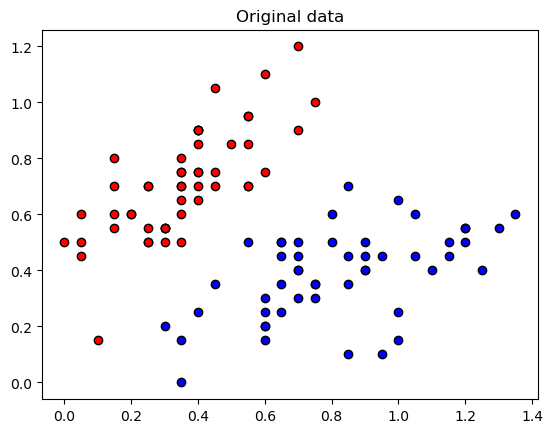

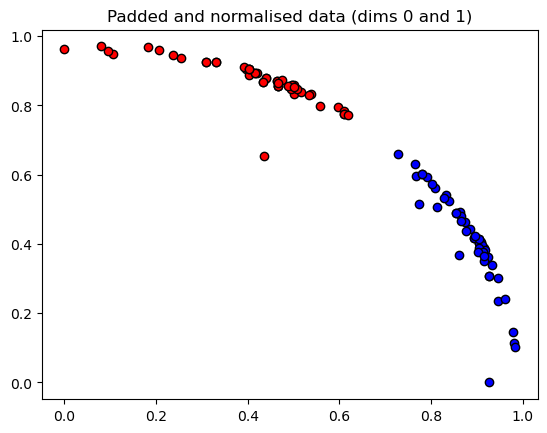

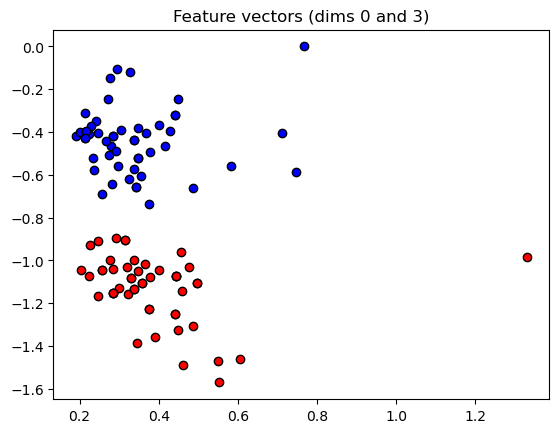

In [20]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(X[:, 0][Y == 1], X[:, 1][Y == 1], c="b", marker="o", ec="k")
plt.scatter(X[:, 0][Y == -1], X[:, 1][Y == -1], c="r", marker="o", ec="k")
plt.title("Original data")
plt.show()

plt.figure()
dim1 = 0
dim2 = 1
plt.scatter(X_norm[:, dim1][Y == 1], X_norm[:, dim2][Y == 1], c="b", marker="o", ec="k")
plt.scatter(X_norm[:, dim1][Y == -1], X_norm[:, dim2][Y == -1], c="r", marker="o", ec="k")
plt.title(f"Padded and normalised data (dims {dim1} and {dim2})")
plt.show()

plt.figure()
dim1 = 0
dim2 = 3
plt.scatter(features[:, dim1][Y == 1], features[:, dim2][Y == 1], c="b", marker="o", ec="k")
plt.scatter(features[:, dim1][Y == -1], features[:, dim2][Y == -1], c="r", marker="o", ec="k")
plt.title(f"Feature vectors (dims {dim1} and {dim2})")
plt.show()

### Split the dataset 
By setting the random seed and shuffling the data, it ensures that the training and validation sets are randomly selected but consistent across different runs. This is crucial for training and evaluating machine learning models, as it allows for fair and consistent performance assessment. 

In [21]:
np.random.seed(0)
num_data = len(Y)
num_train = int(0.75 * num_data)
index = np.random.permutation(range(num_data))
feats_train = features[index[:num_train]]
Y_train = Y[index[:num_train]]
feats_val = features[index[num_train:]]
Y_val = Y[index[num_train:]]

# We need these later for plotting
X_train = X[index[:num_train]]
X_val = X[index[num_train:]]

### Optimization 
Initialize the variables

In [22]:
num_qubits = 2
num_layers = 6

weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

### Training
- Train a variational quantum classifier using mini-batch gradient descent with Nesterov momentum. 
- It updates the model parameters iteratively to minimize the cost function, while periodically logging the training progress and performance on both the training and validation sets. 

In [23]:
opt = NesterovMomentumOptimizer(0.01)
batch_size = 5

# train the variational classifier
weights = weights_init
bias = bias_init
for it in range(60):
    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, num_train, (batch_size,))
    feats_train_batch = feats_train[batch_index]
    Y_train_batch = Y_train[batch_index]
    weights, bias, _, _ = opt.step(cost, weights, bias, feats_train_batch, Y_train_batch)

    # Compute predictions on train and validation set
    predictions_train = np.sign(variational_classifier(weights, bias, feats_train.T))
    predictions_val = np.sign(variational_classifier(weights, bias, feats_val.T))

    # Compute accuracy on train and validation set
    acc_train = accuracy(Y_train, predictions_train)
    acc_val = accuracy(Y_val, predictions_val)

    if (it + 1) % 2 == 0:
        _cost = cost(weights, bias, features, Y)
        print(
            f"Iter: {it + 1:5d} | Cost: {_cost:0.7f} | "
            f"Acc train: {acc_train:0.7f} | Acc validation: {acc_val:0.7f}"
        )

Iter:     2 | Cost: 1.6589456 | Acc train: 0.4800000 | Acc validation: 0.5600000
Iter:     4 | Cost: 1.2054273 | Acc train: 0.4933333 | Acc validation: 0.5600000
Iter:     6 | Cost: 0.9740740 | Acc train: 0.4933333 | Acc validation: 0.7200000
Iter:     8 | Cost: 0.9660872 | Acc train: 0.6400000 | Acc validation: 0.6400000
Iter:    10 | Cost: 0.9569019 | Acc train: 0.6000000 | Acc validation: 0.6000000
Iter:    12 | Cost: 0.9445863 | Acc train: 0.4933333 | Acc validation: 0.7200000
Iter:    14 | Cost: 1.0339978 | Acc train: 0.4800000 | Acc validation: 0.5600000
Iter:    16 | Cost: 1.0774217 | Acc train: 0.4933333 | Acc validation: 0.5600000
Iter:    18 | Cost: 0.9984426 | Acc train: 0.4800000 | Acc validation: 0.5600000
Iter:    20 | Cost: 0.8975279 | Acc train: 0.5600000 | Acc validation: 0.7600000
Iter:    22 | Cost: 0.8451699 | Acc train: 0.6400000 | Acc validation: 0.6400000
Iter:    24 | Cost: 0.8337489 | Acc train: 0.5600000 | Acc validation: 0.5200000
Iter:    26 | Cost: 0.783202

### Visualize the decision regions 
- A grid of points and preprocesses them to match the input format of the classifier.
- The trained variational classifier to predict the class for each grid point.


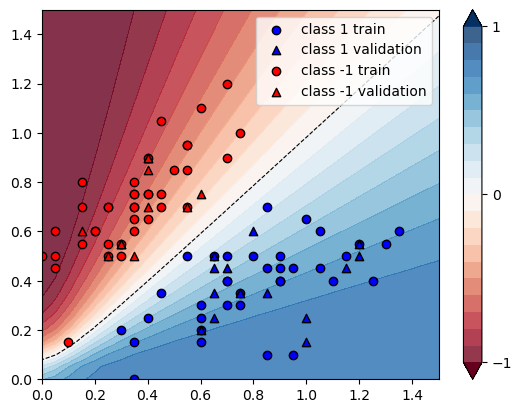

In [24]:
plt.figure()
cm = plt.cm.RdBu

# make data for decision regions
xx, yy = np.meshgrid(np.linspace(0.0, 1.5, 30), np.linspace(0.0, 1.5, 30))
X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]

# preprocess grid points like data inputs above
padding = 0.1 * np.ones((len(X_grid), 2))
X_grid = np.c_[X_grid, padding]  # pad each input
normalization = np.sqrt(np.sum(X_grid**2, -1))
X_grid = (X_grid.T / normalization).T  # normalize each input
features_grid = np.array([get_angles(x) for x in X_grid])  # angles are new features
predictions_grid = variational_classifier(weights, bias, features_grid.T)
Z = np.reshape(predictions_grid, xx.shape)

# plot decision regions
levels = np.arange(-1, 1.1, 0.1)
cnt = plt.contourf(xx, yy, Z, levels=levels, cmap=cm, alpha=0.8, extend="both")
plt.contour(xx, yy, Z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,))
plt.colorbar(cnt, ticks=[-1, 0, 1])

# plot data
for color, label in zip(["b", "r"], [1, -1]):
    plot_x = X_train[:, 0][Y_train == label]
    plot_y = X_train[:, 1][Y_train == label]
    plt.scatter(plot_x, plot_y, c=color, marker="o", ec="k", label=f"class {label} train")
    plot_x = (X_val[:, 0][Y_val == label],)
    plot_y = (X_val[:, 1][Y_val == label],)
    plt.scatter(plot_x, plot_y, c=color, marker="^", ec="k", label=f"class {label} validation")

plt.legend()
plt.show()

# References
- https://pennylane.ai/qml/demos/tutorial_variational_classifier/